# Week 9 - homework: generative convolutional models

-- Prof. Dorien Herremans

Please run the whole notebook with your code and submit the `.ipynb` file on eDimension that includes your answers [so after you run it]. 

In [1]:
from termcolor import colored

student_number="1004657"
student_name="Samuel Sim Wei Xuan"

print(colored("Homework by "  + student_name + ', number: ' + student_number,'red'))

Homework by Samuel Sim Wei Xuan, number: 1004657


 ## Question 1 -- Generate images based on a condition

Task: develop a generative model (either cGAN or cVaE) that can generate images based on a class label (bee or ant). In other words: if I input bee, generate me an image of a bee. If I input ant, generate an image of an ant. 

a) Training dataset: small subset of ImageNet: https://download.pytorch.org/tutorial/hymenoptera_data.zip. You can leverage the ImageFolder class as demonstrated here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html. Since we don't need a test set for generation, you can combine both test and training datasets. 

To handle using custom datasets, torchvision provides a datasets.ImageFolder class. ImageFolder expects data to be stored in the following way:

*   root/class_x/xxy.png
*   root/class_x/xxz.jpg
*   root/class_y/123.jpeg
*   root/class_y/nsdf3.png
*   root/class_y/asd932_.jpg

In [2]:
!pip install wget
import os
import wget
import zipfile
import shutil

# Downloading, unzipping and combining the train, validation files
wget.download("https://download.pytorch.org/tutorial/hymenoptera_data.zip")
with zipfile.ZipFile("hymenoptera_data.zip", 'r') as zip_ref:
    zip_ref.extractall()

os.makedirs('hymenoptera_data/ants', exist_ok=True)
os.makedirs('hymenoptera_data/bees', exist_ok=True)

for filename in os.listdir("hymenoptera_data/train/ants"):
    os.rename("hymenoptera_data/train/ants/" + filename, "hymenoptera_data/ants/" + filename)
for filename in os.listdir("hymenoptera_data/val/ants"):
    os.rename("hymenoptera_data/val/ants/" + filename, "hymenoptera_data/ants/" + filename)

for filename in os.listdir("hymenoptera_data/train/bees"):
    os.rename("hymenoptera_data/train/bees/" + filename, "hymenoptera_data/bees/" + filename)
for filename in os.listdir("hymenoptera_data/val/bees"):
    os.rename("hymenoptera_data/val/bees/" + filename, "hymenoptera_data/bees/" + filename)

os.remove("hymenoptera_data.zip")
shutil.rmtree('hymenoptera_data/train', ignore_errors=True)
shutil.rmtree('hymenoptera_data/val', ignore_errors=True)

b) Normalize the training data and perform data augmentation. For those interested in knowing how to calculate the means for normalizing, please refer to this excellent resource here: https://github.com/bentrevett/pytorch-image-classification/blob/master/5_resnet.ipynb and the previously mentioned link. 


In [3]:
from torchvision import datasets, models, transforms
import torch.utils.data as data
import torch

# Normalize and data augmentation (using pretrained model, need ensure same as the model used for training)
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224), # 1. crop the center 224*224 pixels of the image
        transforms.RandomHorizontalFlip(), # 2. randomly flip the image horizontally
        transforms.ToTensor(), # 3. convert the image to a tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 4. normalize the image
    ])
    
data_directory = './hymenoptera_data'
image_datasets = datasets.ImageFolder(data_directory, data_transforms)
dataloader = data.DataLoader(image_datasets, batch_size=8, shuffle=True)

c:\Users\samue\anaconda3\envs\data_science\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



c) Show a few images from the dataset so we understand what we are working with. 



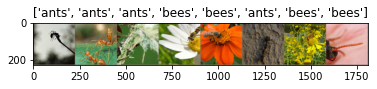

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Get a batch of the training data from the data loader and make a grid
inputs, classes = next(iter(dataloader))
outputs = make_grid(inputs)

# Get the class labels for the training data
class_names = image_datasets.classes

# Plot the images in the batch, along with the corresponding class labels
def imshow_tensor(tensors_images, title):
    images = tensors_images.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406]) # mean of normalization
    std = np.array([0.229, 0.224, 0.225]) # std of normalization
    images = std * images + mean # unnormalize to get back original
    images = np.clip(images, 0, 1) # clip to [0, 1] for visualization

    plt.imshow(images)
    plt.title(title)
    
imshow_tensor(outputs, title=[class_names[x] for x in classes])


d) Implement a conditional generative model. Use at least one convolutional layer in your generative model and define a loss function that makes sense for this problem. 


In [5]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 50
num_epochs = 200
batch_size = 8
capacity = 32
learning_rate = 1e-4
variational_beta = 1
use_gpu = True
img_size = inputs.shape[3] # 224

In [6]:
import time
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from PIL import Image
from torch import autograd
from torch.autograd import Variable

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.label_emb = nn.Embedding(2, img_size*img_size) # 2 classes, dimensions of the embedding is 224*224 resized later in forward
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=c, kernel_size=4, stride=2, padding=1) 
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) 
        self.conv3 = nn.Conv2d(in_channels=c*2, out_channels=c*4, kernel_size=4, stride=2, padding=1) 
        self.conv4 = nn.Conv2d(in_channels=c*4, out_channels=c*8, kernel_size=4, stride=2, padding=1)
        self.fc_mu = nn.Linear(in_features=c*8*14*14, out_features=latent_dims) 
        self.fc_logvar = nn.Linear(in_features=c*8*14*14, out_features=latent_dims) 
            
    def forward(self, x, labels):
        c = self.label_emb(labels) # (batch_size, 224*224)
        c = c.view(-1, 1, 224, 224) # (batch_size, 1, 224, 224)
        x = torch.cat([x, c], axis=1) # (batch_size, 4, 224, 224)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        # notice, here we use use x for mu and for variance! 
        x_mu = self.fc_mu(x) 
        x_logvar = self.fc_logvar(x) #we don't calculate this from x_mu but from x
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.label_emb = nn.Embedding(2, 1)  # 2 classes, dimensions of the embedding is 1 (reverse of encoder)
        c = capacity
        self.fc1 = nn.Linear(in_features=latent_dims+1, out_features=c*8*14*14)
        self.conv4 = nn.ConvTranspose2d(in_channels=c*8, out_channels=c*4, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(in_channels=c*4, out_channels=c*2, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x, labels):
        c = self.label_emb(labels) # (batch_size, 1)
        x = torch.cat([x, c], axis=1) # (batch_size, latent_dims+1)
        x = self.fc1(x)
        x = x.view(x.size(0), capacity*8, 14, 14) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = self.conv1(x)
        return x 

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x, labels):
        # remember our encoder output consists of x_mu, x_logvar, and labels now
        latent_mu, latent_logvar = self.encoder(x, labels)
        # we sample from the distributions defined by mu and logvar, function latent_sample defined below
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent, labels)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_() #define normal distribution
            return eps.mul(std).add_(mu) #sample from normal distribution
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.mse_loss(recon_x.view(-1, 3*224*224), x.view(-1, 3*224*224), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence


e) Train the network on cuda (I recommend to be clever and use a technique such as mini batches to train effectively, optional though). Show how the loss of the model evolves during training. 

f) Generate 4 images of each class after a number of epochs so we can see the generation quality improving during training. This should be done regularly during training so you can follow the process. 





VariationalAutoencoder(
  (encoder): Encoder(
    (label_emb): Embedding(2, 50176)
    (conv1): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=50176, out_features=50, bias=True)
    (fc_logvar): Linear(in_features=50176, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (label_emb): Embedding(2, 1)
    (fc1): Linear(in_features=51, out_features=50176, bias=True)
    (conv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2),

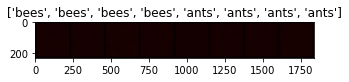

Epoch [2 / 200] average reconstruction error: 1701057.263750
Epoch [3 / 200] average reconstruction error: 1617475.156250
Epoch [4 / 200] average reconstruction error: 1493868.676875
Epoch [5 / 200] average reconstruction error: 1271313.267500
Epoch [6 / 200] average reconstruction error: 1051690.135000
Epoch [7 / 200] average reconstruction error: 980412.336250
Epoch [8 / 200] average reconstruction error: 898129.058125
Epoch [9 / 200] average reconstruction error: 881726.956250
Epoch [10 / 200] average reconstruction error: 869067.271250
Epoch [11 / 200] average reconstruction error: 832375.090000


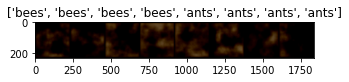

Epoch [12 / 200] average reconstruction error: 808096.703750
Epoch [13 / 200] average reconstruction error: 798396.593125
Epoch [14 / 200] average reconstruction error: 773142.338750
Epoch [15 / 200] average reconstruction error: 759507.582500
Epoch [16 / 200] average reconstruction error: 713435.631250
Epoch [17 / 200] average reconstruction error: 665394.041250
Epoch [18 / 200] average reconstruction error: 661183.726875
Epoch [19 / 200] average reconstruction error: 634189.756875
Epoch [20 / 200] average reconstruction error: 626637.559375
Epoch [21 / 200] average reconstruction error: 606590.955625


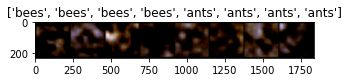

Epoch [22 / 200] average reconstruction error: 610947.299375
Epoch [23 / 200] average reconstruction error: 584139.970625
Epoch [24 / 200] average reconstruction error: 579850.893750
Epoch [25 / 200] average reconstruction error: 577616.485625
Epoch [26 / 200] average reconstruction error: 567827.280000
Epoch [27 / 200] average reconstruction error: 557682.874375
Epoch [28 / 200] average reconstruction error: 560022.494375
Epoch [29 / 200] average reconstruction error: 558819.558125
Epoch [30 / 200] average reconstruction error: 556314.673750
Epoch [31 / 200] average reconstruction error: 561272.187500


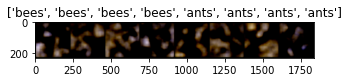

Epoch [32 / 200] average reconstruction error: 545194.935000
Epoch [33 / 200] average reconstruction error: 544861.761875
Epoch [34 / 200] average reconstruction error: 541431.364375
Epoch [35 / 200] average reconstruction error: 536864.710625
Epoch [36 / 200] average reconstruction error: 530634.860000
Epoch [37 / 200] average reconstruction error: 531814.073750
Epoch [38 / 200] average reconstruction error: 528857.882500
Epoch [39 / 200] average reconstruction error: 528868.600625
Epoch [40 / 200] average reconstruction error: 528016.940625
Epoch [41 / 200] average reconstruction error: 526783.185625


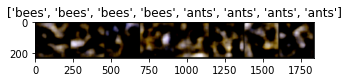

Epoch [42 / 200] average reconstruction error: 523632.594062
Epoch [43 / 200] average reconstruction error: 525192.030000
Epoch [44 / 200] average reconstruction error: 521133.019375
Epoch [45 / 200] average reconstruction error: 522671.268125
Epoch [46 / 200] average reconstruction error: 523848.534375
Epoch [47 / 200] average reconstruction error: 507564.571250
Epoch [48 / 200] average reconstruction error: 515153.475625
Epoch [49 / 200] average reconstruction error: 520557.561250
Epoch [50 / 200] average reconstruction error: 517555.675000
Epoch [51 / 200] average reconstruction error: 513533.862187


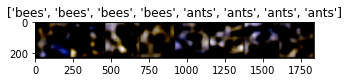

Epoch [52 / 200] average reconstruction error: 506368.383750
Epoch [53 / 200] average reconstruction error: 513929.225625
Epoch [54 / 200] average reconstruction error: 508961.565625
Epoch [55 / 200] average reconstruction error: 505458.926250
Epoch [56 / 200] average reconstruction error: 522830.976250
Epoch [57 / 200] average reconstruction error: 503974.012500
Epoch [58 / 200] average reconstruction error: 516614.125312
Epoch [59 / 200] average reconstruction error: 499230.497812
Epoch [60 / 200] average reconstruction error: 504665.450000
Epoch [61 / 200] average reconstruction error: 509298.773750


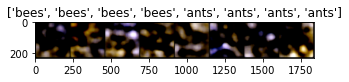

Epoch [62 / 200] average reconstruction error: 508237.008125
Epoch [63 / 200] average reconstruction error: 507280.120000
Epoch [64 / 200] average reconstruction error: 516727.643750
Epoch [65 / 200] average reconstruction error: 510092.292500
Epoch [66 / 200] average reconstruction error: 507146.360000
Epoch [67 / 200] average reconstruction error: 503790.600625
Epoch [68 / 200] average reconstruction error: 509205.792500
Epoch [69 / 200] average reconstruction error: 502786.783750
Epoch [70 / 200] average reconstruction error: 505137.546250
Epoch [71 / 200] average reconstruction error: 500768.329375


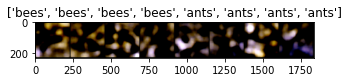

Epoch [72 / 200] average reconstruction error: 509295.453750
Epoch [73 / 200] average reconstruction error: 500293.203125
Epoch [74 / 200] average reconstruction error: 508511.670625
Epoch [75 / 200] average reconstruction error: 505270.451875
Epoch [76 / 200] average reconstruction error: 496920.146875
Epoch [77 / 200] average reconstruction error: 503744.032500
Epoch [78 / 200] average reconstruction error: 485907.869063
Epoch [79 / 200] average reconstruction error: 493659.779687
Epoch [80 / 200] average reconstruction error: 508105.733750
Epoch [81 / 200] average reconstruction error: 502457.455625


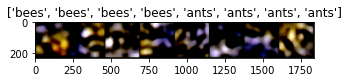

Epoch [82 / 200] average reconstruction error: 504147.156875
Epoch [83 / 200] average reconstruction error: 496800.818125
Epoch [84 / 200] average reconstruction error: 502291.222500
Epoch [85 / 200] average reconstruction error: 491943.461875
Epoch [86 / 200] average reconstruction error: 504131.507500
Epoch [87 / 200] average reconstruction error: 504348.714375
Epoch [88 / 200] average reconstruction error: 486396.537187
Epoch [89 / 200] average reconstruction error: 490494.421875
Epoch [90 / 200] average reconstruction error: 501997.928750
Epoch [91 / 200] average reconstruction error: 497637.599375


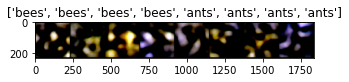

Epoch [92 / 200] average reconstruction error: 493022.748125
Epoch [93 / 200] average reconstruction error: 499912.424375
Epoch [94 / 200] average reconstruction error: 498789.876875
Epoch [95 / 200] average reconstruction error: 498646.404375
Epoch [96 / 200] average reconstruction error: 492775.629375
Epoch [97 / 200] average reconstruction error: 487948.103750
Epoch [98 / 200] average reconstruction error: 479721.994375
Epoch [99 / 200] average reconstruction error: 481203.249688
Epoch [100 / 200] average reconstruction error: 470268.828750
Epoch [101 / 200] average reconstruction error: 471655.126250


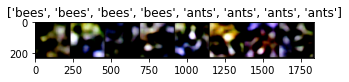

Epoch [102 / 200] average reconstruction error: 463358.136875
Epoch [103 / 200] average reconstruction error: 453336.928438
Epoch [104 / 200] average reconstruction error: 470596.233125
Epoch [105 / 200] average reconstruction error: 449720.254375
Epoch [106 / 200] average reconstruction error: 450414.920938
Epoch [107 / 200] average reconstruction error: 447621.790000
Epoch [108 / 200] average reconstruction error: 449486.391875
Epoch [109 / 200] average reconstruction error: 450603.198750
Epoch [110 / 200] average reconstruction error: 435219.979375
Epoch [111 / 200] average reconstruction error: 437030.259375


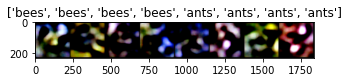

Epoch [112 / 200] average reconstruction error: 437006.895625
Epoch [113 / 200] average reconstruction error: 448124.791250
Epoch [114 / 200] average reconstruction error: 441701.157187
Epoch [115 / 200] average reconstruction error: 439503.265625
Epoch [116 / 200] average reconstruction error: 444938.052500
Epoch [117 / 200] average reconstruction error: 440664.768125
Epoch [118 / 200] average reconstruction error: 447185.850625
Epoch [119 / 200] average reconstruction error: 448882.207188
Epoch [120 / 200] average reconstruction error: 437316.775625
Epoch [121 / 200] average reconstruction error: 440535.506875


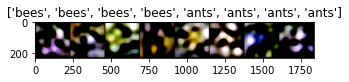

Epoch [122 / 200] average reconstruction error: 444843.058437
Epoch [123 / 200] average reconstruction error: 435335.526250
Epoch [124 / 200] average reconstruction error: 434575.526875
Epoch [125 / 200] average reconstruction error: 438035.742188
Epoch [126 / 200] average reconstruction error: 444583.329688
Epoch [127 / 200] average reconstruction error: 441781.394688
Epoch [128 / 200] average reconstruction error: 439034.816250
Epoch [129 / 200] average reconstruction error: 437627.217500
Epoch [130 / 200] average reconstruction error: 434397.309375
Epoch [131 / 200] average reconstruction error: 442088.874375


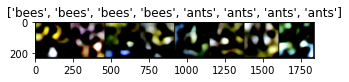

Epoch [132 / 200] average reconstruction error: 445659.184375
Epoch [133 / 200] average reconstruction error: 441621.987500
Epoch [134 / 200] average reconstruction error: 434324.064063
Epoch [135 / 200] average reconstruction error: 440694.609375
Epoch [136 / 200] average reconstruction error: 438703.744375
Epoch [137 / 200] average reconstruction error: 432529.148750
Epoch [138 / 200] average reconstruction error: 437287.294375
Epoch [139 / 200] average reconstruction error: 436616.559063
Epoch [140 / 200] average reconstruction error: 441084.418125
Epoch [141 / 200] average reconstruction error: 430163.184063


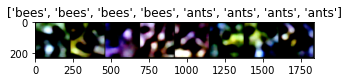

Epoch [142 / 200] average reconstruction error: 430080.902813
Epoch [143 / 200] average reconstruction error: 440112.643125
Epoch [144 / 200] average reconstruction error: 441299.639062
Epoch [145 / 200] average reconstruction error: 438533.280000
Epoch [146 / 200] average reconstruction error: 447729.225625
Epoch [147 / 200] average reconstruction error: 441723.864375
Epoch [148 / 200] average reconstruction error: 440599.955000
Epoch [149 / 200] average reconstruction error: 437103.402500
Epoch [150 / 200] average reconstruction error: 441396.617812
Epoch [151 / 200] average reconstruction error: 438251.541875


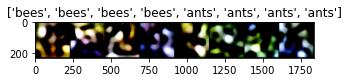

Epoch [152 / 200] average reconstruction error: 444466.689375
Epoch [153 / 200] average reconstruction error: 430157.183750
Epoch [154 / 200] average reconstruction error: 437198.574062
Epoch [155 / 200] average reconstruction error: 433097.982812
Epoch [156 / 200] average reconstruction error: 433118.528125
Epoch [157 / 200] average reconstruction error: 437997.663125
Epoch [158 / 200] average reconstruction error: 430857.610625
Epoch [159 / 200] average reconstruction error: 431483.105312
Epoch [160 / 200] average reconstruction error: 438240.431250
Epoch [161 / 200] average reconstruction error: 439902.978125


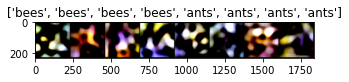

Epoch [162 / 200] average reconstruction error: 432638.479687
Epoch [163 / 200] average reconstruction error: 436338.898438
Epoch [164 / 200] average reconstruction error: 429454.978750
Epoch [165 / 200] average reconstruction error: 434511.544687
Epoch [166 / 200] average reconstruction error: 437732.232187
Epoch [167 / 200] average reconstruction error: 432767.577500
Epoch [168 / 200] average reconstruction error: 437947.115625
Epoch [169 / 200] average reconstruction error: 439912.919375
Epoch [170 / 200] average reconstruction error: 430870.922500
Epoch [171 / 200] average reconstruction error: 439669.771875


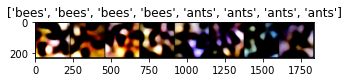

Epoch [172 / 200] average reconstruction error: 421905.929063
Epoch [173 / 200] average reconstruction error: 437268.590625
Epoch [174 / 200] average reconstruction error: 430786.355000
Epoch [175 / 200] average reconstruction error: 432111.240938
Epoch [176 / 200] average reconstruction error: 431181.918438
Epoch [177 / 200] average reconstruction error: 427612.676875
Epoch [178 / 200] average reconstruction error: 435098.945312
Epoch [179 / 200] average reconstruction error: 435044.080000
Epoch [180 / 200] average reconstruction error: 425600.159375
Epoch [181 / 200] average reconstruction error: 427642.025938


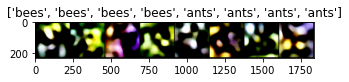

Epoch [182 / 200] average reconstruction error: 429735.541250
Epoch [183 / 200] average reconstruction error: 428869.198750
Epoch [184 / 200] average reconstruction error: 432391.891875
Epoch [185 / 200] average reconstruction error: 432143.250000
Epoch [186 / 200] average reconstruction error: 441582.581562
Epoch [187 / 200] average reconstruction error: 435481.780000
Epoch [188 / 200] average reconstruction error: 431941.033125
Epoch [189 / 200] average reconstruction error: 442596.545312
Epoch [190 / 200] average reconstruction error: 435725.162500
Epoch [191 / 200] average reconstruction error: 429049.036250


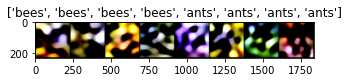

Epoch [192 / 200] average reconstruction error: 438490.129688
Epoch [193 / 200] average reconstruction error: 428651.311250
Epoch [194 / 200] average reconstruction error: 424241.958750
Epoch [195 / 200] average reconstruction error: 425410.736250
Epoch [196 / 200] average reconstruction error: 435542.255312
Epoch [197 / 200] average reconstruction error: 434183.312500
Epoch [198 / 200] average reconstruction error: 430386.995312
Epoch [199 / 200] average reconstruction error: 428973.727187
Epoch [200 / 200] average reconstruction error: 428642.605625


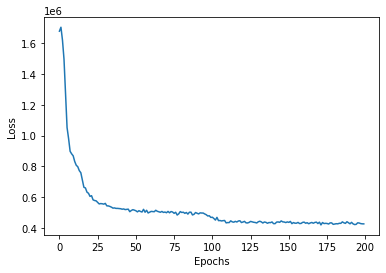

In [7]:
# for generating of batch images
def show_image(img, classes):
    img = img.clamp(0,1)
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0))
    plt.title(classes)
    plt.imshow(img)

# train the network
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = VariationalAutoencoder().to(device)
print(vae)

optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)
train_loss_avg = []

for epoch in range(num_epochs):
    # set to training mode
    vae.train()
    train_loss_avg.append(0)  
    num_batches = 0 
    for image_batch, labels in dataloader:   

        image_batch = image_batch.to(device)
        labels = labels.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch, labels)   

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)  

        # backpropagation
        optimizer.zero_grad()
        loss.backward()        

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()        

        train_loss_avg[-1] += loss.item()    
        num_batches += 1    

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

    # Generate a batch of images every 10 epochs
    if epoch % 10 == 0:
        vae.eval()
        with torch.no_grad():
            # sample latent vectors from the normal distribution
            latent = torch.randn(batch_size, latent_dims).to(device)
            # reconstruct images from the latent vectors
            labels = torch.LongTensor([1,1,1,1,0,0,0,0]).to(device)
            classes = [class_names[i] for i in labels]
            img_recon = vae.decoder(latent, labels)
            img_recon = img_recon.cpu()
            fig, ax = plt.subplots(figsize=(5, 5))
            show_image(make_grid(img_recon.data[:8],8,5), classes)
            plt.show()
            
# loss evolve during training
plt.ion()
fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

g) Showcase how your model can now take an input option and generate the appropriate image. Show this for both ants and bees. 

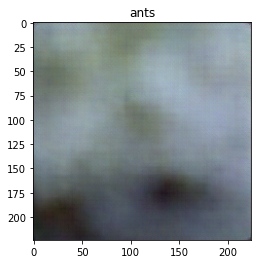

In [8]:
# ASSUMPTION: Takes in a single image and generate the single image
def predict_single_image(image_path, str_label:str):
    # Prepare the image and label for the model
    image = Image.open(image_path)
    image = image.resize((224, 224), Image.ANTIALIAS)
    image = np.array(image)
    image = image.transpose((2, 0, 1))
    image = torch.from_numpy(image).float().unsqueeze(0)
    image = image.to(device)
    label = torch.LongTensor([class_names.index(str_label)]).to(device)

    # run image through model
    vae.eval()
    image_recon, latent_mu, latent_logvar = vae(image, label)
    image_recon = image_recon.cpu()
    
    # convert to numpy for display
    image_to_display = image_recon.data.squeeze(0)
    image_to_display = image_to_display.cpu()
    image_to_display = image_to_display.numpy()
    image_to_display = np.transpose(image_to_display, (1, 2, 0))
    
    # display image
    plt.title(str_label)
    plt.imshow(image_to_display/255)

    # return image_recon
    
predict_single_image('hymenoptera_data/ants/6240329_72c01e663e.jpg', 'ants')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


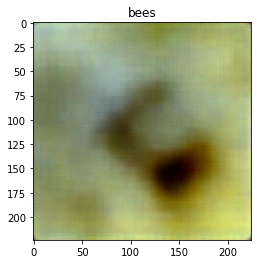

In [9]:
predict_single_image('hymenoptera_data/bees/522104315_5d3cb2758e.jpg', 'bees')

h) Does this model work well enough? What might be the reason for this? Do you have any suggestions for improvement? 


In [10]:
# number of images for our training
len(image_datasets)

397

From the output images, we can tell the model does not work well enough. This could be due to the small size of training data as shown above, hence our model is unable to capture the features well. An easy yet expensive improvement would be to collect more data.

i) Is the loss function enough to assess the quality of the images? If not, how could you improve the evaluation? 

No, using a loss function alone is not enough to assess the quality of the images. In fact using MSE pixel loss does not adequately capture the images qualities that we humans desire, in terms of the aesthetics and quality. Here is a very nice article illustrating so, https://medium.com/@olegrybkin_20684/the-reasonable-ineffectiveness-of-mse-pixel-loss-for-future-prediction-and-what-to-do-about-it-4dca8152355d. Instead, we can make use of other evaluation metrics such as structural similarity index measure (SSIM) or even the common Peak signal-to-noise ratio (PSNR).